<a href="https://colab.research.google.com/github/tjwikki12/Ideathon/blob/main/Ideathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
# spacy.require_gpu()
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df=pd.read_csv("/content/reviews.csv")

In [ ]:
df.columns

Index(['User', 'Location', 'Review Date', 'Rating', 'Review Highlight',
       'Review', 'Date of Experience'],
      dtype='object')

In [ ]:
df.rename(columns={'Review Highlight': 'content'}, inplace=True)

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import spacy
import re

# Load a pre-trained SpaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Example Telecom Glossary
telecom_glossary = set([
    '5g', 'wifi', 'router', 'fiber', 'mobile', 'signal', 'network', 'internet', 'lte', 'sms', 'carrier', 'bandwidth', 'data', 'tower'
])

# Function to clean the text
def clean_text(text):
    # Process the text with spaCy to detect named entities
    doc = nlp(text)

    # Remove personal names (NER entities of type "PERSON")
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            text = text.replace(ent.text, ' ')

    # Convert to lowercase
    text = text.lower()

    # Remove text inside square brackets (e.g., [product] or [info])
    text = re.sub(r'\[.*?\]', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove words containing numbers (e.g., phone123)
    text = re.sub(r'\b\w*\d\w*\b', ' ', text)

    # Preserve telecom glossary words by checking against the glossary set
    words = text.split()
    cleaned_words = [word if word in telecom_glossary else word for word in words]
    text = ' '.join(cleaned_words)

    return text

In [ ]:
# Clean text columns
df['content_clean'] = df['content'].progress_apply(lambda x: clean_text(x))

100%|██████████| 4480/4480 [00:38<00:00, 116.70it/s]


In [ ]:
import spacy
from tqdm import tqdm

# Load the pre-trained spaCy model
nlp = spacy.load("en_core_web_sm")

# Access stopwords directly via `nlp.Defaults.stop_words`
stopwords = nlp.Defaults.stop_words

# Define the lemmatization function
def lemmatization(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):  # Efficient processing with nlp.pipe
        # Lemmatize, remove stopwords, and join tokens back into a string
        sent = [token.lemma_ for token in doc if not token.is_stop]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences

In [ ]:
df['content_lemmatized'] = lemmatization(df['content_clean'])

4480it [00:04, 1047.53it/s]


In [ ]:
def extract_pos_tags(texts):
    pos_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        # Extracting all nouns (singular, plural, proper nouns)
        sent = [token.text for token in doc if token.pos_ == 'NOUN']
        pos_sentences.append(' '.join(sent))  # Join the nouns into a single string
    return pos_sentences

In [ ]:
#Write your function to extract the POS tags only for NN
def extract_pos_tags(texts):
    pos_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.text for token in doc if token.tag_ == 'NN']
        pos_sentences.append(' '.join(sent))
    return pos_sentences



In [ ]:
df["content_POS_removed"] = extract_pos_tags(df['content_clean'])

4480it [00:04, 909.89it/s]


In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
df['content_length'] = df['content_clean'].str.len()
df['content_lemmatized_length'] = df['content_lemmatized'].str.len()
df['content_POS_removed_length'] = df['content_POS_removed'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df['content_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df['content_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df['content_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='content Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

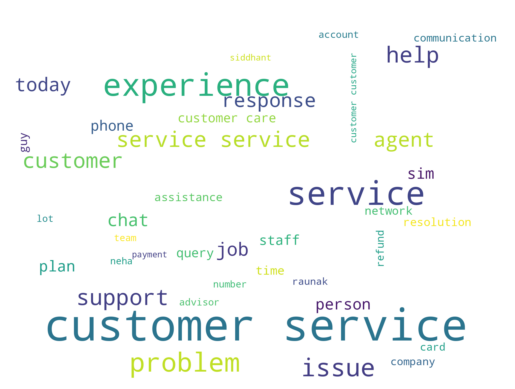

In [ ]:
from wordcloud import WordCloud
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df['content_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df['content_clean'] = df['content_POS_removed'].str.replace('-PRON-', '')

In [ ]:
# function to get the specified top n-grams
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [ ]:
#Print the top 10 words in the unigram frequency and plot the same using a bar graph
unigram = get_top_n_words(df['content_clean'], 1,10)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 10 Unigrams')

service 868
customer 608
experience 203
problem 139
issue 124
help 100
support 98
agent 83
response 77
today 71


In [ ]:
#Print the top 10 words in the bigram frequency and plot the same using a bar graph
bigram = get_top_n_words(df['content_clean'], 2,10)
for word, freq in bigram:
    print(word, freq)
px.bar(x=[word for word, freq in bigram], y=[freq for word, freq in bigram], title='Top 10 Bigrams')

customer service 445
customer care 31
customer support 20
service experience 13
service today 10
customer experience 8
service customer 8
class service 8
service agent 7
service raunak 7


In [ ]:
#Print the top 10 words in the trigram frequency and plot the same using a bar graph
trigram = get_top_n_words(df['content_clean'], 3,10)
for word, freq in trigram:
    print(word, freq)
px.bar(x=[word for word, freq in trigram], y=[freq for word, freq in trigram], title='Top 10 Trigram')

customer service experience 9
customer care service 6
customer service team 6
customer service agent 6
customer service today 5
customer service representative 5
notch customer service 4
experience customer service 3
customer service raunak 3
customer service chat 2


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Define the categories with representative keywords or descriptions
categories = {
    'Network': ['network', 'signal', 'tower', 'connection', 'bandwidth', 'wifi'],
    'Mobile': ['mobile', '5g', 'data', 'cell', 'LTE', 'smartphone'],
    'Customer Service': ['support', 'service', 'help', 'assist', 'response', 'call center','customer experience','service experience','customer service','customer support','service agent'],
    'Billing': ['billing', 'payment', 'invoice', 'charge', 'subscription'],
    'Internet': ['internet', 'router', 'fiber', 'bandwidth', 'connection']

}

# Step 2: Prepare the category descriptions
category_descriptions = {}
for category, keywords in categories.items():
    category_descriptions[category] = ' '.join(keywords)

# Step 3: Vectorize the content_clean column and category descriptions using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the TF-IDF vectorizer on the category descriptions and content_clean together
category_vectors = vectorizer.fit_transform(list(category_descriptions.values()))
content_vectors = vectorizer.transform(df['content_clean'])

# Step 4: Calculate the cosine similarity between each content entry and all categories
def get_category(content_vector):
    similarities = cosine_similarity(content_vector, category_vectors)
    # Get the category with the highest similarity score
    category_index = np.argmax(similarities)
    return list(category_descriptions.keys())[category_index]

# Step 5: Apply the function to categorize the content
df['category'] = [get_category(content_vector) for content_vector in content_vectors]




In [ ]:
import plotly.express as px

# Step 1: Count the number of reviews in each category
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Step 2: Create a bar chart to visualize the distribution of reviews by category
fig = px.bar(category_counts, x='Category', y='Count',
             title='Distribution of Reviews by Category',
             labels={'Category': 'Category', 'Count': 'Number of Reviews'},
             color='Category',
             color_continuous_scale='Viridis')

# Show the bar chart
fig.show()


In [ ]:
df['category'].value_counts()

,count
category,
Network,2955
Customer Service,1478
Billing,18
Mobile,16
Internet,13


In [ ]:
def classify_review_content(review):
    # Check if the review is a valid string before processing
    if isinstance(review, str):
        # Convert the review to lowercase to make the search case-insensitive
        review = review.lower()

        # Check for keywords and assign categories
        if 'network' in review or 'signal' in review or 'coverage' in review:
            return 'Network'
        elif 'customer service' in review or 'help' in review or 'support' in review:
            return 'Customer Service'
        elif 'mobile' in review or 'phone' in review or 'cell' in review or 'smartphone' in review:
            return 'Mobile'
        elif 'billing' in review or 'payment' in review or 'charges' in review or 'invoice' in review:
            return 'Billing'
        elif 'internet' in review or 'wifi' in review or 'connection' in review or 'online' in review:
            return 'Internet'
        else:
            return 'Other'  # Default category if none of the keywords are found
    else:
        return 'Other'  # If it's not a string, categorize it as 'Other'

def match_category(review, category):
    # Check if the review is a valid string before processing
    if isinstance(review, str):
        # Convert the review to lowercase to make the search case-insensitive
        review = review.lower()

        # Check if the review contains keywords related to the assigned category
        if category == 'Network':
            if 'network' in review or 'signal' in review or 'coverage' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        elif category == 'Customer Service':
            if 'customer service' in review or 'help' in review or 'support' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        elif category == 'Mobile':
            if 'mobile' in review or 'phone' in review or 'cell' in review or 'smartphone' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        elif category == 'Billing':
            if 'billing' in review or 'payment' in review or 'charges' in review or 'invoice' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        elif category == 'Internet':
            if 'internet' in review or 'wifi' in review or 'connection' in review or 'online' in review:
                return 'Matched'
            else:
                return 'Mismatch'
        else:
            return 'Mismatch'
    else:
        return 'Mismatch'  # If it's not a string, categorize as mismatch




In [ ]:
# Apply the functions to classify and match categories for each review
df['review_category'] = df['Review'].apply(classify_review_content)
df['category_match'] = df.apply(lambda row: match_category(row['Review'], row['review_category']), axis=1)

In [ ]:
def combine_columns(row):
    if row['category'] == row['review_category']:
        return row['category']  # If values are similar, keep the value from either column
    else:
        return row['category']

# Apply the function to create a new column
df['category_'] = df.apply(combine_columns, axis=1)

In [ ]:
df = df.drop(columns=['category_match'])

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.3 MB/s eta 0:00:00


In [ ]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define the sentiment map to convert text labels to numeric values
sentiment_map = {
    'Positive': 2,  # Assigning 'Positive' to 2
    'Neutral': 1,   # Assigning 'Neutral' to 1
    'Negative': 0   # Assigning 'Negative' to 0
}

# Function to classify sentiment with handling for NaN or empty reviews
def get_sentiment(review):
    if pd.isna(review) or review == "":  # Check for NaN or empty strings
        return 'Neutral'  # Default to Neutral if review is empty or NaN

    sentiment_score = analyzer.polarity_scores(review)
    compound_score = sentiment_score['compound']

    # Classify based on the compound score
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis function to the 'Review' column
df['sentiment'] = df['Review'].apply(get_sentiment)

# Convert the sentiment values to numeric using the sentiment_map
df['sentiment_numeric'] = df['sentiment'].map(sentiment_map)




In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
Positive,3693
Neutral,487
Negative,300


In [ ]:
# Visualize the sentiment distribution
import plotly.express as px

# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Plot the sentiment distribution
fig = px.bar(sentiment_counts, x='Sentiment', y='Count',
             title='Sentiment Distribution of Reviews',
             labels={'Sentiment': 'Sentiment', 'Count': 'Number of Reviews'},
             color='Sentiment',
             color_continuous_scale='Viridis')

fig.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Vectorize the cleaned text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['content_clean'])

# Convert sparse matrix to DataFrame for easy manipulation
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())


In [ ]:
# Check the shape of X_tfidf_df and sentiment_numeric
print(X_tfidf_df.shape)  # Should show (n_samples, 5000)
print(df[['sentiment_numeric']].shape)  # Should show (n_samples, 1)


In [ ]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())  # Convert sparse matrix to DataFrame
X = X_tfidf_df
y = df['category_']
X.columns = X.columns.astype(str)

In [ ]:
print(y
      )

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model with class_weight='balanced' and 100 estimators
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict using the test set
y_pred = model.predict(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the RandomForest model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider for splitting a node
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print(f"Best parameters: {grid_search.best_params_}")



Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# Set up cross-validation
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Print classification report for each fold
    print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

In [ ]:
# Save the trained model and vectorizer using joblib
import joblib
joblib.dump(model, 'review_classifier_model_rf.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


In [ ]:
# Load the trained model and TF-IDF vectorizer
model = joblib.load('review_classifier_model_rf.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [ ]:
# Sample 5 random rows from the 'content' column
test_data = df['content'].sample(n=5)

# Display the test data
print(test_data)


In [ ]:
# Transform the test data using the same TF-IDF vectorizer
test_data_tfidf = vectorizer.transform(test_data)

# Check the shape of the transformed data
print(f"Test data shape after TF-IDF: {test_data_tfidf.shape}")


In [ ]:
predictions = model.predict(test_data_tfidf)  # Use xgb.predict(test_data_tfidf) if using XGBoost

# Display the predictions
print(f"Predictions: {predictions}")

In [ ]:
df.head(5)